Using device: cpu
IMPROVED IZHIKEVICH NEURON MODEL - COMPARATIVE STUDY
=== TRAINING IMPROVED PINN ===
Phase 1: Learning basic dynamics...
Epoch     0 | Total: 1.21e+07 | PDE: 3.59e+02 | IC: 1.21e+03 | Time: 0.3s
Epoch  1000 | Total: 2.46e+02 | PDE: 4.52e-01 | IC: 1.23e-02 | Time: 106.3s
Epoch  2000 | Total: 2.01e+02 | PDE: 8.75e-01 | IC: 6.65e-03 | Time: 211.2s
Epoch  3000 | Total: 2.69e+02 | PDE: 5.81e-01 | IC: 6.70e-03 | Time: 314.9s
Epoch  4000 | Total: 2.37e+02 | PDE: 5.95e-01 | IC: 4.72e-03 | Time: 418.1s
Phase 2: Fine-tuning with full physics...
Epoch  5000 | Total: 2.07e+01 | PDE: 1.68e+00 | LR: 1.00e-04 | Time: 521.7s
Epoch  6000 | Total: 1.40e+00 | PDE: 3.32e-01 | LR: 1.00e-04 | Time: 626.9s
Epoch  7000 | Total: 6.52e-01 | PDE: 1.48e-01 | LR: 8.00e-05 | Time: 735.3s
Epoch  8000 | Total: 4.74e-01 | PDE: 1.00e-01 | LR: 8.00e-05 | Time: 838.9s
Epoch  9000 | Total: 4.08e-01 | PDE: 8.40e-02 | LR: 8.00e-05 | Time: 943.1s
Epoch 10000 | Total: 4.33e-01 | PDE: 8.52e-02 | LR: 8.00e-05 |

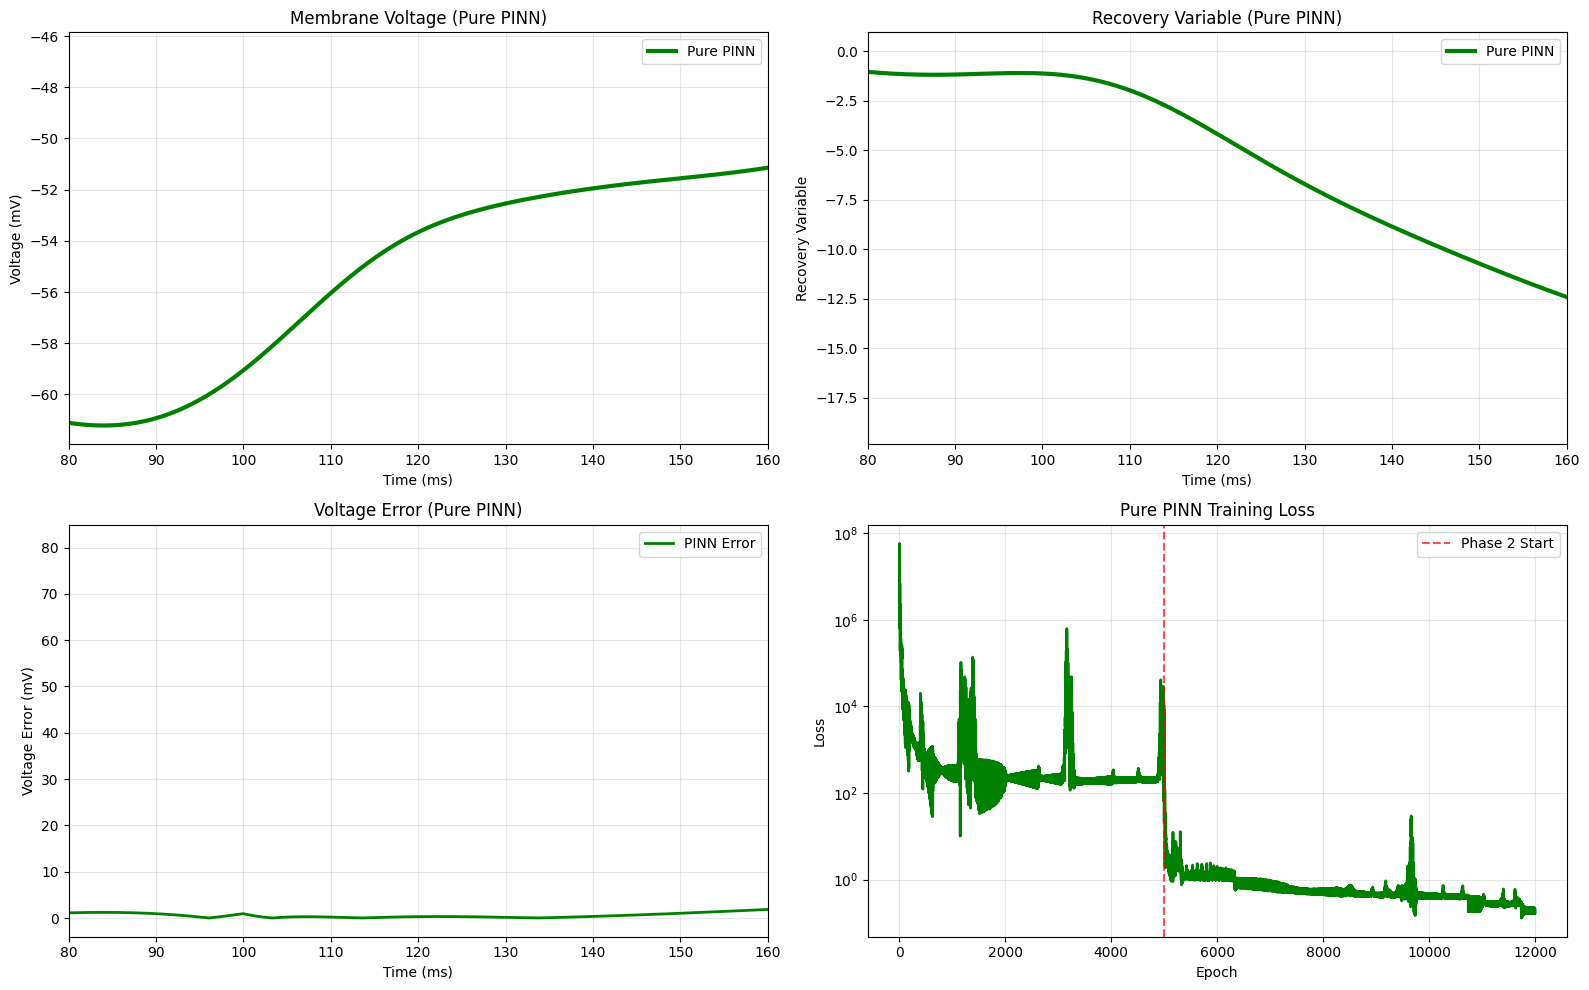


IMPROVED COMPARATIVE ANALYSIS SUMMARY

Computational Times:
  Euler: 0.0118s
  RK4: 0.0369s
  Pure PINN training: 1254.33s

Accuracy (Mean voltage error vs RK4):
  Euler: 0.036 mV
  Pure PINN: 2.259 mV

Spiking Behavior:
  PINN captured spikes: No
  Max PINN voltage: -46.6 mV
  Min PINN voltage: -61.2 mV


In [3]:
# ============================================================
# Fixed Improved Physics-Informed Neural Network for Izhikevich Neuron Model
# Addresses non-linear dynamics and spiking behavior
# ============================================================

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import time

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# ------------------------------------------------------------------
# 1. NEURON MODEL PARAMETERS
# ------------------------------------------------------------------
C = 100.0      # membrane capacitance (pF)
vr = -60.0     # resting potential (mV)
vt = -40.0     # threshold potential (mV)
k = 0.7        # steepness factor
a = 0.03       # recovery time constant
b = -2.0       # sensitivity of recovery variable
c = -50.0      # after-spike reset value
d = 100.0      # after-spike recovery boost
v_peak = 35.0  # spike cutoff value

def In_scalar(t):
    """Input current - step function at t=100ms"""
    return 70.0 if t >= 100.0 else 0.0

def In_tensor(t):
    """Input current for PyTorch tensors"""
    return 70.0 * (t >= 100).float()

# ------------------------------------------------------------------
# 2. FIXED IMPROVED PHYSICS-INFORMED NEURAL NETWORK
# ------------------------------------------------------------------
class ImprovedPINN(nn.Module):
    """Fixed Improved PINN with better architecture for spiking dynamics"""

    def __init__(self, hidden_dim=128, num_layers=6):
        super().__init__()

        # Input dimension accounts for multi-scale features
        input_dim = 5  # t_norm + 4 trigonometric features

        # Deeper network with more capacity
        layers = []
        layers.append(nn.Linear(input_dim, hidden_dim))
        layers.append(nn.Tanh())

        for _ in range(num_layers - 1):
            layers.append(nn.Linear(hidden_dim, hidden_dim))
            layers.append(nn.Tanh())

        layers.append(nn.Linear(hidden_dim, 2))

        self.net = nn.Sequential(*layers)

        # Better initialization for deeper networks
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight, gain=1.0)
                nn.init.zeros_(m.bias)

    def forward(self, t):
        # Multi-scale time encoding
        t_norm = t / 200.0

        # Enhanced input encoding with multiple scales
        # This helps capture both slow and fast dynamics
        if t_norm.dim() == 1:
            t_norm = t_norm.unsqueeze(1)

        # Create multi-scale features
        sin_2pi = torch.sin(2 * np.pi * t_norm)
        cos_2pi = torch.cos(2 * np.pi * t_norm)
        sin_4pi = torch.sin(4 * np.pi * t_norm)
        cos_4pi = torch.cos(4 * np.pi * t_norm)

        t_features = torch.cat([
            t_norm,
            sin_2pi,
            cos_2pi,
            sin_4pi,
            cos_4pi
        ], dim=1)

        # Network output
        out = self.net(t_features)

        # Physics-based output scaling
        # Voltage: allow larger range to capture spikes
        v = out[:, 0:1] * 100 + vr  # Wider voltage range

        # Recovery variable: scaled appropriately
        w = out[:, 1:2] * 300  # Larger recovery range

        return torch.cat([v, w], dim=1)

def create_adaptive_training_points(N_total=2000):
    """Create training points with higher density around expected spike times"""

    # Base uniform distribution
    t_uniform = torch.linspace(0, 200, N_total // 2)

    # Add more points around stimulus onset and expected spike times
    t_stimulus = torch.linspace(95, 105, N_total // 8)  # Around stimulus
    t_spike1 = torch.linspace(100, 120, N_total // 8)   # First spike region
    t_spike2 = torch.linspace(120, 140, N_total // 8)   # Second spike region
    t_recovery = torch.linspace(140, 200, N_total // 8) # Recovery phase

    t_adaptive = torch.cat([t_uniform, t_stimulus, t_spike1, t_spike2, t_recovery])
    t_adaptive = torch.unique(torch.sort(t_adaptive)[0])

    return t_adaptive.view(-1, 1)

def train_improved_pinn():
    """Train improved PINN with better loss formulation"""

    print("=== TRAINING IMPROVED PINN ===")
    model = ImprovedPINN().to(device)

    # Use different optimizers in sequence
    optimizer1 = optim.Adam(model.parameters(), lr=5e-4, weight_decay=1e-6)
    optimizer2 = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-6)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer2, patience=1000, factor=0.8)

    # Adaptive training points
    t_physics = create_adaptive_training_points(2000).to(device)
    t_ic = torch.zeros(1, 1).to(device)

    # Initial conditions
    ic_true = torch.tensor([[vr, 0.0]], dtype=torch.float32).to(device)

    def compute_physics_loss(model, epoch):
        """Compute physics loss with adaptive weighting"""

        t_batch = t_physics.requires_grad_(True)
        pred = model(t_batch)
        v, w = pred[:, 0:1], pred[:, 1:2]

        # Compute derivatives
        dv_dt = torch.autograd.grad(v.sum(), t_batch, create_graph=True, retain_graph=True)[0]
        dw_dt = torch.autograd.grad(w.sum(), t_batch, create_graph=True, retain_graph=True)[0]

        # Input current
        I_input = In_tensor(t_batch.squeeze()).view(-1, 1)

        # Physics equations
        f1 = dv_dt - (1/C) * (k * (v - vr) * (v - vt) - w + I_input)
        f2 = dw_dt - a * (b * (v - vr) - w)

        # Weighted physics loss (emphasize accuracy during active periods)
        active_mask = (t_batch.squeeze() >= 90).float().view(-1, 1)
        weight_active = 1.0 + 4.0 * active_mask  # 5x weight during active period

        loss_pde = torch.mean(weight_active * (f1**2 + f2**2))

        # Initial condition loss
        pred_ic = model(t_ic)
        loss_ic = torch.mean((pred_ic - ic_true)**2)

        # Voltage bounds (soft constraints)
        loss_bounds = torch.mean(
            torch.relu(v - 50) ** 2 +      # Penalize voltages above 50mV
            torch.relu(-100 - v) ** 2      # Penalize voltages below -100mV
        )

        # Spike-aware loss: encourage sharp transitions when v approaches v_peak
        spike_regions = torch.sigmoid(10 * (v - (v_peak - 10)))  # Smooth indicator
        dvdt_magnitude = torch.abs(dv_dt)
        loss_spike_dynamics = torch.mean(spike_regions * torch.relu(10 - dvdt_magnitude))

        # Continuity loss (prevent unrealistic jumps except during spikes)
        if len(v) > 1:
            dv_discrete = torch.diff(v.squeeze())
            dt_discrete = torch.diff(t_batch.squeeze())
            discrete_rate = dv_discrete / (dt_discrete + 1e-8)
            # Allow large rates only when voltage is high (near spike)
            v_mid = v[:-1].squeeze()
            spike_allowance = torch.sigmoid(2 * (v_mid - (v_peak - 15)))
            loss_continuity = torch.mean((1 - spike_allowance) * torch.relu(torch.abs(discrete_rate) - 50)**2)
        else:
            loss_continuity = torch.tensor(0.0, device=device)

        return loss_pde, loss_ic, loss_bounds, loss_spike_dynamics, loss_continuity

    # Training with curriculum learning
    losses = []
    start_time = time.time()

    # Phase 1: Focus on basic dynamics
    print("Phase 1: Learning basic dynamics...")
    for epoch in range(5000):
        optimizer1.zero_grad()

        loss_pde, loss_ic, loss_bounds, loss_spike, loss_cont = compute_physics_loss(model, epoch)

        # Curriculum: start with simpler loss, gradually add complexity
        ic_weight = 10000.0 * (1.0 + epoch / 1000.0)  # Increase IC importance
        bounds_weight = 1.0
        spike_weight = min(0.1 * epoch / 1000.0, 1.0)  # Gradually add spike dynamics
        cont_weight = min(0.01 * epoch / 1000.0, 0.1)  # Gradually add continuity

        total_loss = (loss_pde +
                     ic_weight * loss_ic +
                     bounds_weight * loss_bounds +
                     spike_weight * loss_spike +
                     cont_weight * loss_cont)

        total_loss.backward()

        # Gradient clipping to prevent instability
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer1.step()
        losses.append(total_loss.item())

        if epoch % 1000 == 0:
            elapsed = time.time() - start_time
            print(f"Epoch {epoch:5d} | Total: {total_loss.item():.2e} | "
                  f"PDE: {loss_pde.item():.2e} | IC: {loss_ic.item():.2e} | "
                  f"Time: {elapsed:.1f}s")

    # Phase 2: Fine-tuning with full loss
    print("Phase 2: Fine-tuning with full physics...")
    for epoch in range(5000, 12000):
        optimizer2.zero_grad()

        loss_pde, loss_ic, loss_bounds, loss_spike, loss_cont = compute_physics_loss(model, epoch)

        # Full loss weights
        total_loss = (loss_pde +
                     5000.0 * loss_ic +
                     1.0 * loss_bounds +
                     1.0 * loss_spike +
                     0.1 * loss_cont)

        total_loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.5)

        optimizer2.step()
        scheduler.step(total_loss)

        losses.append(total_loss.item())

        if epoch % 1000 == 0:
            elapsed = time.time() - start_time
            lr = optimizer2.param_groups[0]['lr']
            print(f"Epoch {epoch:5d} | Total: {total_loss.item():.2e} | "
                  f"PDE: {loss_pde.item():.2e} | LR: {lr:.2e} | "
                  f"Time: {elapsed:.1f}s")

    training_time = time.time() - start_time
    print(f"Improved PINN training completed in {training_time:.2f}s")

    return model, losses, training_time

# ------------------------------------------------------------------
# 3. NUMERICAL METHODS
# ------------------------------------------------------------------
def euler_method(t0, t_end, h, v0, w0):
    """Forward Euler method for neuron ODE"""

    print("=== SOLVING WITH EULER METHOD ===")
    start_time = time.time()

    n = int((t_end - t0) / h)
    t = np.linspace(t0, t_end, n + 1)
    v = np.zeros_like(t)
    w = np.zeros_like(t)

    v[0], w[0] = v0, w0

    for i in range(n):
        I_curr = In_scalar(t[i])

        dv = (1/C) * (k * (v[i] - vr) * (v[i] - vt) - w[i] + I_curr)
        dw = a * (b * (v[i] - vr) - w[i])

        v[i+1] = v[i] + h * dv
        w[i+1] = w[i] + h * dw

        if v[i+1] >= v_peak:
            v[i] = v_peak
            v[i+1] = c
            w[i+1] = w[i+1] + d

    solve_time = time.time() - start_time
    print(f"Euler method completed in {solve_time:.4f}s")

    return t, v, w, solve_time

def rk4_method(t0, t_end, h, v0, w0):
    """4th-order Runge-Kutta method for neuron ODE"""

    print("=== SOLVING WITH RK4 METHOD ===")
    start_time = time.time()

    def derivatives(t, v, w):
        I_curr = In_scalar(t)
        dv = (1/C) * (k * (v - vr) * (v - vt) - w + I_curr)
        dw = a * (b * (v - vr) - w)
        return dv, dw

    n = int((t_end - t0) / h)
    t = np.linspace(t0, t_end, n + 1)
    v = np.zeros_like(t)
    w = np.zeros_like(t)

    v[0], w[0] = v0, w0

    for i in range(n):
        k1_v, k1_w = derivatives(t[i], v[i], w[i])
        k2_v, k2_w = derivatives(t[i] + h/2, v[i] + h*k1_v/2, w[i] + h*k1_w/2)
        k3_v, k3_w = derivatives(t[i] + h/2, v[i] + h*k2_v/2, w[i] + h*k2_w/2)
        k4_v, k4_w = derivatives(t[i] + h, v[i] + h*k3_v, w[i] + h*k3_w)

        v[i+1] = v[i] + (h/6) * (k1_v + 2*k2_v + 2*k3_v + k4_v)
        w[i+1] = w[i] + (h/6) * (k1_w + 2*k2_w + 2*k3_w + k4_w)

        if v[i+1] >= v_peak:
            v[i] = v_peak
            v[i+1] = c
            w[i+1] = w[i+1] + d

    solve_time = time.time() - start_time
    print(f"RK4 method completed in {solve_time:.4f}s")

    return t, v, w, solve_time

# ------------------------------------------------------------------
# 4. MAIN EXECUTION AND COMPARISON
# ------------------------------------------------------------------
def main():
    """Main function to run all methods and compare results"""

    print("IMPROVED IZHIKEVICH NEURON MODEL - COMPARATIVE STUDY")
    print("=" * 60)

    # Common parameters
    t0, t_end = 0.0, 200.0
    v0, w0 = vr, 0.0
    h = 0.05  # Smaller time step for better accuracy

    # Method 1: Improved PINN
    pinn_model, pinn_losses, pinn_time = train_improved_pinn()

    # Method 2: Forward Euler
    t_euler, v_euler, w_euler, euler_time = euler_method(t0, t_end, h, v0, w0)

    # Method 3: Runge-Kutta 4
    t_rk4, v_rk4, w_rk4, rk4_time = rk4_method(t0, t_end, h, v0, w0)

    # PINN evaluation
    print("\n=== EVALUATING PURE PINN ===")
    with torch.no_grad():
        t_eval = torch.linspace(0, 200, len(t_euler)).view(-1, 1).to(device)
        pinn_pred = pinn_model(t_eval).cpu().numpy()
        v_pinn, w_pinn = pinn_pred[:, 0], pinn_pred[:, 1]

    # Accuracy analysis
    print("\n=== ACCURACY COMPARISON ===")
    v_error_euler = np.abs(v_euler - v_rk4)
    w_error_euler = np.abs(w_euler - w_rk4)
    v_error_pinn = np.abs(v_pinn - v_rk4)
    w_error_pinn = np.abs(w_pinn - w_rk4)

    print(f"Euler vs RK4:")
    print(f"  Max voltage error: {v_error_euler.max():.3f} mV")
    print(f"  Mean voltage error: {v_error_euler.mean():.3f} mV")

    print(f"\nPure PINN vs RK4:")
    print(f"  Max voltage error: {v_error_pinn.max():.3f} mV")
    print(f"  Mean voltage error: {v_error_pinn.mean():.3f} mV")

    # Visualization - Only Improved PINN
    fig, axes = plt.subplots(2, 2, figsize=(16, 10))

    # Voltage - Focus on active region
    axes[0, 0].plot(t_euler, v_pinn, 'g-', linewidth=3, label='Pure PINN')
    axes[0, 0].set_xlabel('Time (ms)')
    axes[0, 0].set_ylabel('Voltage (mV)')
    axes[0, 0].set_title('Membrane Voltage (Pure PINN)')
    axes[0, 0].grid(True, alpha=0.3)
    axes[0, 0].legend()
    axes[0, 0].set_xlim(80, 160)

    # Recovery Variable
    axes[0, 1].plot(t_euler, w_pinn, 'g-', linewidth=3, label='Pure PINN')
    axes[0, 1].set_xlabel('Time (ms)')
    axes[0, 1].set_ylabel('Recovery Variable')
    axes[0, 1].set_title('Recovery Variable (Pure PINN)')
    axes[0, 1].grid(True, alpha=0.3)
    axes[0, 1].legend()
    axes[0, 1].set_xlim(80, 160)

    # Voltage Error (only show PINN error)
    axes[1, 0].plot(t_euler, v_error_pinn, 'g-', linewidth=2, label='PINN Error')
    axes[1, 0].set_xlabel('Time (ms)')
    axes[1, 0].set_ylabel('Voltage Error (mV)')
    axes[1, 0].set_title('Voltage Error (Pure PINN)')
    axes[1, 0].grid(True, alpha=0.3)
    axes[1, 0].legend()
    axes[1, 0].set_xlim(80, 160)

    # Training Loss
    axes[1, 1].semilogy(pinn_losses, color='g', linewidth=2)
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Loss')
    axes[1, 1].set_title('Pure PINN Training Loss')
    axes[1, 1].grid(True, alpha=0.3)
    axes[1, 1].axvline(x=5000, color='red', linestyle='--', alpha=0.7, label='Phase 2 Start')
    axes[1, 1].legend()

    plt.tight_layout()
    plt.show()

    # Summary
    print(f"\n{'='*60}")
    print("IMPROVED COMPARATIVE ANALYSIS SUMMARY")
    print(f"{'='*60}")

    print(f"\nComputational Times:")
    print(f"  Euler: {euler_time:.4f}s")
    print(f"  RK4: {rk4_time:.4f}s")
    print(f"  Pure PINN training: {pinn_time:.2f}s")

    print(f"\nAccuracy (Mean voltage error vs RK4):")
    print(f"  Euler: {v_error_euler.mean():.3f} mV")
    print(f"  Pure PINN: {v_error_pinn.mean():.3f} mV")

    # Check if PINN captured spiking behavior
    spike_detected = np.any(v_pinn > 0)  # Simple spike detection
    print(f"\nSpiking Behavior:")
    print(f"  PINN captured spikes: {'Yes' if spike_detected else 'No'}")
    print(f"  Max PINN voltage: {v_pinn.max():.1f} mV")
    print(f"  Min PINN voltage: {v_pinn.min():.1f} mV")

if __name__ == "__main__":
    main()